# KNN Regression Algorithm

In [26]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [27]:
DATE_TIME_COLUMNS = ['DATETIME_INI', 'DATETIME_FIM']

ds = pd.read_csv('../../../data/preprocessed.csv', index_col='PES_ID', parse_dates=DATE_TIME_COLUMNS)

In [28]:
ds["DATETIME_INI"] = ds["DATETIME_INI"].apply(lambda x: time.mktime(x.timetuple()))
ds["DATETIME_FIM"] = ds["DATETIME_FIM"].apply(lambda x: time.mktime(x.timetuple()))

In [29]:
# Correlation coefficients for 'PES_PESOUTIL' with the other variables. The closer they are to 1, the more correlation there is.
# Very high correlations mean that you can expect a straightforward modeling process.
# Source: Real Python (https://realpython.com/knn-python/#a-step-by-step-knn-from-scratch-in-python)
correlation_matrix = ds.corr()
correlation_matrix['PES_PESOUTIL']

LOCDESCARREGO_ID    0.138133
EMP_ID              0.156482
ROTA_ID            -0.260565
TPVEICULO_DESC     -0.339027
PES_PESOUTIL        1.000000
COLETA_ID          -0.344953
ESPECCOLETA_ID     -0.349337
PERCUSSO_I         -0.148184
LOCAL_ID           -0.006706
TPCIRCUITO_DESC    -0.055621
DATETIME_INI       -0.077040
DATETIME_FIM       -0.077036
Name: PES_PESOUTIL, dtype: float64

In [30]:
ds.head()

,LOCDESCARREGO_ID,EMP_ID,ROTA_ID,TPVEICULO_DESC,PES_PESOUTIL,COLETA_ID,ESPECCOLETA_ID,PERCUSSO_I,LOCAL_ID,TPCIRCUITO_DESC,DATETIME_INI,DATETIME_FIM
PES_ID,,,,,,,,,,,,
2490322,7,708,144,3,9640,1,1,2156.0,205,0,1.420081e+09,1.420082e+09
2489495,7,708,144,3,9100,1,1,2156.0,205,0,1.419914e+09,1.419915e+09
2488707,7,708,144,3,3480,1,1,2156.0,205,0,1.419666e+09,1.419667e+09
2488660,7,708,144,3,9370,1,1,2156.0,205,0,1.419655e+09,1.419655e+09
2488114,7,708,144,3,9460,1,1,2156.0,205,0,1.419502e+09,1.419503e+09


In [31]:
target_column_name = 'PES_PESOUTIL'
target_column = ds.pop(target_column_name)

In [32]:
X = ds.to_numpy()
y = target_column.to_numpy()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Parameterizing

In [53]:
# from sklearn.model_selection import GridSearchCV
# # set up our search grid
# param_grid = {"algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               "p": [1, 2],
#               "leaf_size": [10, 30, 50],
#               "n_neighbors": [1, 10, 100, 1000],
#               "weights": ["uniform", "distance"]
# }

# knn_model = KNeighborsRegressor()

# # try out every combination of the above values
# search = GridSearchCV(knn_model, param_grid, cv=10).fit(X_train, y_train)

# print("The best hyperparameters are ",search.best_params_)


The best hyperparameters are  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 100, 'p': 1, 'weights': 'distance'}


In [65]:
params = {'algorithm': 'ball_tree',
          'leaf_size': 30,
          'n_neighbors': 100,
          'weights': 'distance',
          'p': 1
}

In [66]:
knn = KNeighborsRegressor(**params)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=100, p=1,
                    weights='distance')

In [67]:
train_preds = knn.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_rmse = math.sqrt(train_mse)
train_rmse

0.0

In [68]:
test_preds = knn.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = math.sqrt(test_mse)
test_rmse

3743.481989566642

# Cross Validation

In [69]:
import random
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

def cross_validate_model(model, X, y, cv=10):
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=random.randint(0, 1000))
    n_scores = cross_validate(estimator=model,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True
                            )
    return n_scores

# Experimentation

In [70]:
N_ITERATIONS = 5
N_CROSS_VALIDATION = 10

n_scores = []
duration = []

for _ in range(N_ITERATIONS):
    time_start = time.time()
    n_scores.append(cross_validate_model(knn, X, y, cv=N_CROSS_VALIDATION))
    duration.append(time.time() - time_start)

In [ ]:
# print(n_scores)

### Training Duration

In [ ]:
# Create a bar plot
plt.bar(range(1,len(duration)+1), duration)
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Bar Plot of Duration for Each Iteration')
plt.show()

time_training = np.mean(duration)
time_training_std = np.std(duration)

print(f"Training time: {time_training} ± {time_training_std} seconds")

### R² Score

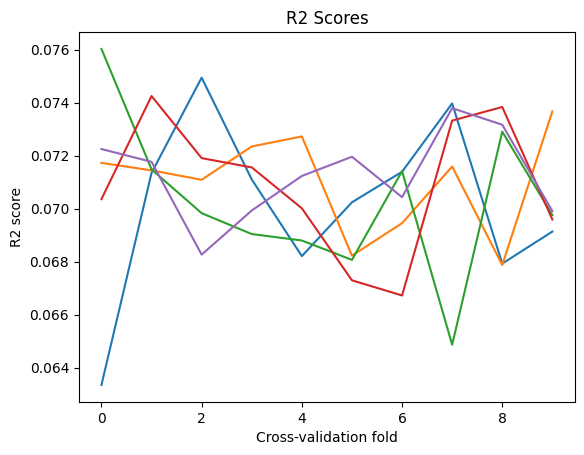

In [72]:
# Reshape the R2 scores
r2_scores = [r2['test_r2'].reshape(-1, 1) for r2 in n_scores]

# Plot the R2 scores
[plt.plot(r2_score, label=f'Fold {i + 1}') for i, r2_score in enumerate(r2_scores)]
plt.xlabel('Cross-validation fold')
plt.ylabel('R2 score')
plt.title('R2 Scores')
plt.show()

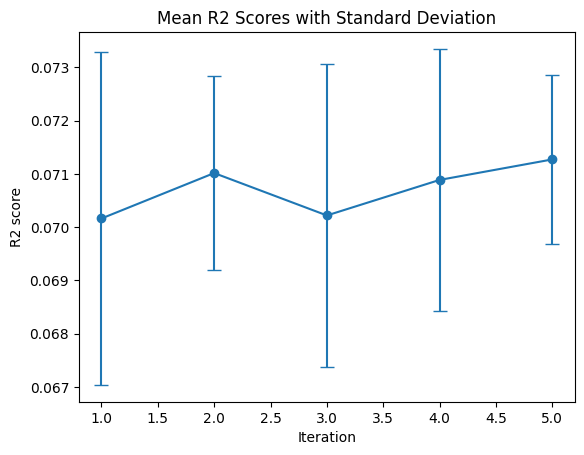

Mean R2: 0.0707
Standard Deviation of R2: 0.0004


In [73]:
# Calculate mean and standard deviation of R2 scores
mean_r2_scores = [r2['test_r2'].mean() for r2 in n_scores]
std_r2_scores = [r2['test_r2'].std() for r2 in n_scores]

# Plot the mean R2 scores with error bars representing the standard deviation
plt.errorbar(range(1, N_ITERATIONS + 1), mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('R2 score')
plt.title('Mean R2 Scores with Standard Deviation')
plt.show()

mean_r2 = sum(mean_r2_scores) / len(mean_r2_scores)
std_mse = np.std(mean_r2_scores)

print("Mean R2: {:.4f}".format(mean_r2))
print("Standard Deviation of R2: {:.4f}".format(std_mse))

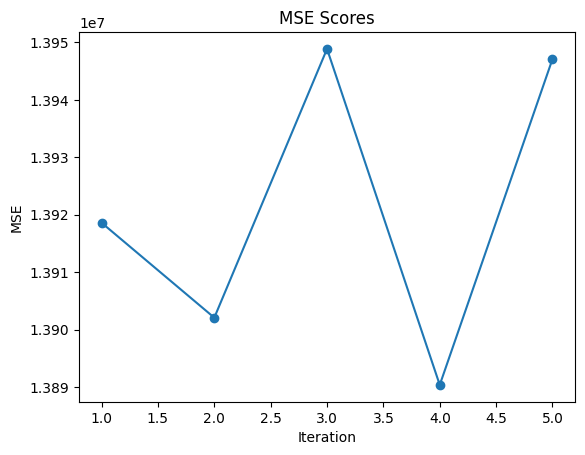

Mean MSE: 13921398.9440
Standard Deviation of MSE: 23498.3826


In [74]:
# Calculate MSE for each fold
mse_scores = [-r2['test_neg_mean_squared_error'].mean() for r2 in n_scores]

# Plot the MSE scores
plt.plot(range(1, N_ITERATIONS + 1), mse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE Scores')
plt.show()

# Calculate mean and standard deviation of MSE scores
mean_mse = sum(mse_scores) / len(mse_scores)
std_mse = np.std(mse_scores)

print("Mean MSE: {:.4f}".format(mean_mse))
print("Standard Deviation of MSE: {:.4f}".format(std_mse))

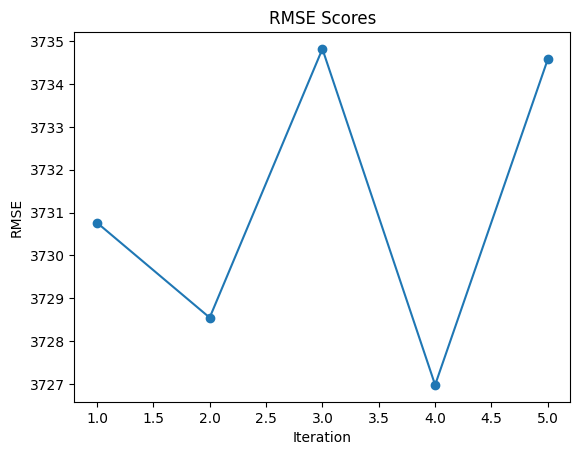

Mean RMSE: 3731.1378
Standard Deviation of RMSE: 3.1489


In [75]:
rmse_scores = [np.sqrt(-r2['test_neg_mean_squared_error'].mean()) for r2 in n_scores]

# Plot the RMSE scores
plt.plot(range(1, N_ITERATIONS + 1), rmse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Scores')
plt.show()

# Calculate mean and standard deviation of RMSE scores
mean_rmse = sum(rmse_scores) / len(rmse_scores)
std_rmse = np.std(rmse_scores)

print("Mean RMSE: {:.4f}".format(mean_rmse))
print("Standard Deviation of RMSE: {:.4f}".format(std_rmse))

## Exporting Metrics

In [ ]:
import os

# Define the filename for the metrics dataset
metrics_filename = "../results.csv"

# Check if the metrics.csv file exists
if os.path.exists(metrics_filename):
    # Load the metrics dataset
    metrics_dataset = pd.read_csv(metrics_filename, index_col='Algorithm')
    
    data = {
        "Mean R2 score": mean_r2,
        "Standard deviation of R2 scores": std_mse,
        "Mean MSE": mean_mse,
        "Standard deviation of MSE": std_mse,
        "Mean RMSE": mean_rmse,
        "Standard deviation of RMSE": std_rmse,
        "Mean Training time": time_training,
        "Standard deviation of Training time": time_training_std
    }
    
    df = pd.DataFrame(data, index=['KNNRegressor_preprocessed'])
    
    metrics_dataset = pd.concat([metrics_dataset, df], axis=0)
    
    # Save the updated metrics dataset
    metrics_dataset.to_csv(metrics_filename, index=True, index_label='Algorithm')
else:
    # The metrics.csv file does not exist, print an error message
    print("The metrics.csv file does not exist.")